In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize
import statsmodels.tools.numdiff as smnd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

3.1 (a) This problem has two hidden subproblems:

1. Why did the authors pick a Gaussian distribution as opposed to an exponential or any other distribution?
2. Given that the Gaussian model is chosen, why do we have to add the scaling factor (describing the amplitude (max - min)) and the background height? 

The answer to #1 is not rigorously justified without resorting to the partial differential equations (PDE's) that govern the physical system (e.g. diffusion equations). Without apriori knowledge about the physical mechanism, we cannot argue that a Gaussian distribution is a better choice than, say an exponential. During a brief chat with Justin on this issue, he told us that an exponential distribution would lead to a cusp on the origin, which is a nonphysical artifact - however, it is not difficult to imagine a hypothetical situation where the exponential could plausibly be a better fit. For this particular problem, it turns out that indeed, the physical mechanism deductively, rigorously and conclusively corroborates the Gaussian model. However, that cannot be argued without resorting to more information than is available in the question.

Back to our problem: The authors picked the Gaussian distribution because it has a well defined finite width (given by sigma), peaks at the origin and decays rapidly (and is hence concordant with what a cursory look at the image suggests). It is a reasonable guess for intuitive reasons. According to Justin, when they wrote the paper, the authors did not know that the PDE's describing the physical system inevitably lead to a Gaussian distribution - it was discovered afterwards.

The answer to #2 is rather trivial. PDF's are defined such that the area under a PDF is 1. Subtracting the background adjusts the vertical location of the Gaussian so that when the algorithm approximates the best Gaussian fit, the y-axis matches the fluorescent range. Scaling stretches or shrinks it so that the area underneath the curve is 1. 

What other models can we recommend? Well, let's consider the boundary limits the distribution would have to satisfy:
1. Peaks at the origin
2. Decays rapidly for large x.
3. Decreases monotonically for increasing and decreasing x.
4. Is symmetric with respect to x.

We think that any mirrored-exponential distribution would satisfy the above conditions, as would any distribution in the form of

\begin{align}
\Large f(x) = A \mathrm{e} ^ {\large-{\lambda x^{\large k}}} + \Large B
\end{align}

where k and lambda are regularization parameters and A and B correspond to scaling and shifting, respectively. 

Let's check whether the Gaussian model makes sense given the raw data:

In [3]:
# Load data into DataFrame
df = pd.read_csv('../data/reeves_dv_profile_over_time.csv', comment='#')

# Check it out
df.head()

,DV coord nc 14,fluor intensity nc 14,DV coord nc 13,fluor intensity nc 13,DV coord nc 12,fluor intensity nc 12,DV coord nc 11,fluor intensity nc 11
0,0.7813,1.6512,0.7939,1.6763,0.9210,1.0523,0.9347,1.2730
1,0.8565,1.4200,0.8404,1.1663,-0.5801,1.4345,-0.9663,1.1778
2,0.8986,1.3845,0.8789,1.3919,-0.5192,1.2087,-0.5628,1.2967
3,0.9286,1.3960,0.9879,1.2993,-0.4795,1.2272,-0.3528,1.4155
4,-0.9356,1.1741,-0.9231,1.2076,-0.3491,1.4272,-0.1478,2.0224


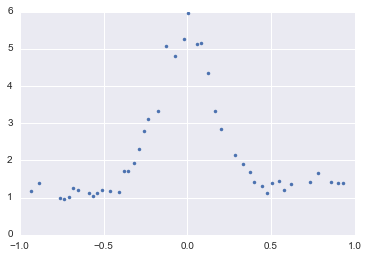

In [4]:
plt.plot(df['DV coord nc 14'], df['fluor intensity nc 14'], marker='.', linestyle='none')

The 14th cell cycle certainly looks promising. Notice that the fluorescence level falls off rapidly and resembles a bell curve. Let's look at the other three:

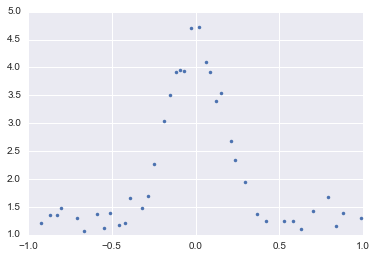

In [5]:
plt.plot(df['DV coord nc 13'], df['fluor intensity nc 13'], marker='.', linestyle='none')

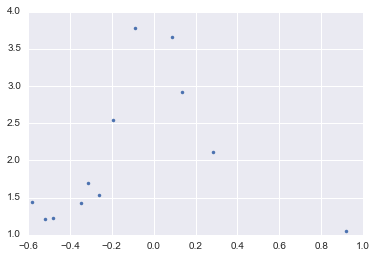

In [6]:
plt.plot(df['DV coord nc 12'], df['fluor intensity nc 12'], marker='.', linestyle='none')

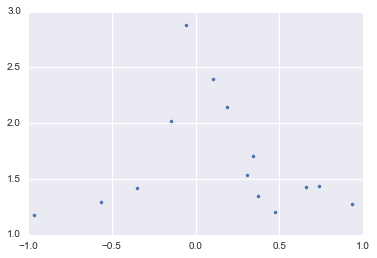

In [7]:
plt.plot(df['DV coord nc 11'], df['fluor intensity nc 11'], marker='.', linestyle='none')

While the last two plots look a lot muddier than the first two, Gaussian seems a reasonable choice for all four data sets. 

3.1 (b) Before we construct our Bayesian equations, it's important to state the underlying mathematical and statistical models:

Mathematical Model: We assume that the fluorescence gradient follows a scaled and shifted Gaussian, described and justified in 3.1.
Statistical Model: We assume that the error between the theoretical fluorescence level and our measurements is Gaussian distributed. Why is this justified? We have reason to think that the error distribution is the sum of a large number of independent, or very weakly correlated random variables. For example, external factors such as temperature, precision of experimental equipment, brightness as well as internal factors like the experimentor's eyesight, reflexes and intuition for the type of experimental setup to use may all have some bearing on the end result. If we can assume that all the possible factors that can produce an experimental error are large in number, not very correlated to each other and obey a mild condition, it can be shown that their sum approaches a Gaussian as the sample size increases (See Lyapunov's CLT). Based on this assumption, we can guess that the resulting error distribution is Gaussian. 

Now, let's set up Bayes' Equation: 

The shape of the likelihood follows from the statistical model: We assume that i.i.d measurements that each consist of the mean and some Gaussian noise. 

\begin{align}
Likelihood = \prod_{i \in D}\frac{1}{\sqrt{2 \pi \sigma_i^2}}\exp{\frac{-(x_i - f(x_i))^2}{2 \sigma_i^2}}   
\end{align}

Here, $f(x_i)$ represents our theoretical Gaussian fit for the fluorescence distribution and $x_i$ represent our measurements.

\begin{align}
f(x_i) = A \exp{[-\frac{1}{2w_i^2} (p_i - \mu)^2]} + B 
\end{align}

As described in 3.1,  $A$, $B$, $w_i$ and $\mu$ are the scaling, shifting, width and mean position parameters, respectively. $p_i$ are the position measurements.

We will assume uniform priors for $A$, $B$, $w$, $\mu$ and Jeffrey's prior for $\sigma$.  Moreover, we assume that all five parameters are independent because of the following reasons: 

- $\sigma$ is independent of f($x_i$) because f($x_i$) specifies the location of the bell curve whereas $\sigma$ sets the width. This shows that $\sigma$ is independent of all the other 4 parameters. Now, we will argue that the other 4 parameters are independent of one another. 

- The location and scale parameters ($A$ and $B$) are independent of the Gaussian behavior (as in, they can be applied to any arbitrary function and are separate from the bell shape). We know that $A$ and $B$ are independent because their effects can be separated ($A$ stretches the curve whereas $B$ shifts it). Similarly, $w$ and $\mu$ are also independent because they too represent the scale and location of the Gaussian bell shape. Overall, it makes intuitive sense that all 4 parameters should be independent of one another. 

- Thus, we can separate the combined prior into a product of five priors:

\begin{align}
Prior = P(A \mid I) P(B \mid I) P(W \mid I) P(\mu \mid I) P(\sigma \mid I)
\end{align}
\begin{align}
      = \frac{1}{A_{max}}\frac{1}{B_{max}}\frac{1}{Width}\frac{1}{\mu_{max}}\frac{1}{\sigma \ln{\frac{\sigma_{max}}{\sigma_{min}}}}
\end{align}


Notice that the posterior is a student-t distribution, as derived earlier in class. It is proportional to an exponential term:
\begin{align}
Posterior \propto (\sum_{i \in D} (x_i - \mu)^2)^{-\frac{n}{2}}
\end{align}

\begin{align}
Log Posterior = - \frac{n}{2} \log{\sum_{i} (x_i - \mu)^2} + constant
\end{align}

3.1 (c) The data are ready for use. We just need to extract each column for further analysis. 

In [8]:
coord_14 = df['DV coord nc 14'].dropna()
fluor_14 = df['fluor intensity nc 14'].dropna()
coord_13 = df['DV coord nc 13'].dropna()
fluor_13 = df['fluor intensity nc 13'].dropna()
coord_12 = df['DV coord nc 12'].dropna()
fluor_12 = df['fluor intensity nc 12'].dropna()
coord_11 = df['DV coord nc 11'].dropna()
fluor_11 = df['fluor intensity nc 11'].dropna()

In [9]:
def find_fluorescence(parameters, position):
    '''  
    Theoretical model for the fluorescence
    '''
    a, b, width, mean_pos = parameters
    return a * np.exp(-1/(2*width**2) * (position - mean_pos)**2) + b

In [10]:
def log_post(parameters, position, fluorescence):
    """
    Compute log of posterior for single set of parameters.
    parameters[0] = a
    parameters[1] = b
    parameters[2] = width
    parameters[3] = mean_pos    
    """
    # Unpack parameters
    a, b, width, mean_pos = parameters
    
    # Theoretical fluorescence
    flu_theor = find_fluorescence(parameters, position)
    
    return -len(position) / 2 * np.log(np.sum((fluorescence - flu_theor)**2))

In [11]:
def resid(parameters, position, fluorescence):
    """
    Residuals for the fluorescence model.
    """
    return fluorescence - find_fluorescence(parameters, position)

We need to plot the raw data before setting the initial guess. We will do all of 3.1 (c) one nuclear cycle at a time.

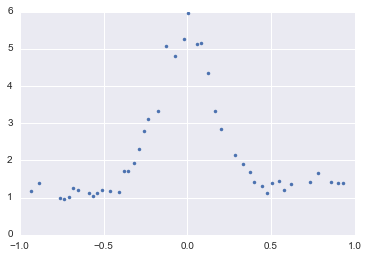

In [12]:
plt.plot(coord_14, fluor_14, marker='.', linestyle='none')

It seems like 5 is a reasonable choice for the amplitude. Similarly, the shift corresponds to aproximately 1. The width is roughly 0.25 and the distribution seems centered around 0. 

In [13]:
p0 = np.array([5, 1, 0.25, 0])

In [14]:
# Extra arguments as a tuple
args = (coord_14.values, fluor_14.values)

In [15]:
# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

In [16]:
popt

array([ 4.29691449,  1.24283676,  0.1624985 , -0.01088087])

The width of the gradient is given by the third element in popt. It's approximately 0.162. Now, let's look at the best fit curve on the same plot with the raw data:

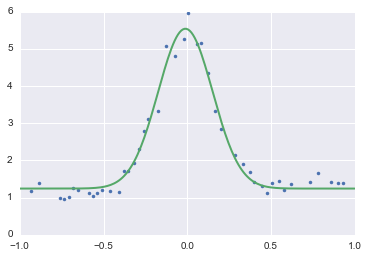

In [17]:
plt.plot(coord_14, fluor_14, marker='.', linestyle='none')
x = np.linspace(-1,1,200)
y = find_fluorescence(popt, x)
plt.plot(x,y)


In [18]:
hes = smnd.approx_hess(popt, log_post, args=args)

In [19]:
hes

array([[  -133.45183369,   -188.72926329,  -1719.95283128,   -124.37016298],
       [  -188.72926329,   -866.70074767,  -5126.64875921,    142.59860578],
       [ -1719.95283128,  -5126.64875921, -70164.94769263,   5454.106795  ],
       [  -124.37016298,    142.59860578,   5454.106795  , -45480.41290045]])

In [20]:
cov = -np.linalg.inv(hes)

In [21]:
cov

array([[  1.21831562e-02,  -1.52937148e-03,  -1.91650077e-04,
         -6.10941541e-05],
       [ -1.52937148e-03,   2.23003394e-03,  -1.25753099e-04,
         -3.90636123e-06],
       [ -1.91650077e-04,  -1.25753099e-04,   2.84132356e-05,
          3.53717449e-06],
       [ -6.10941541e-05,  -3.90636123e-06,   3.53717449e-06,
          2.25664920e-05]])

Now, we find the error bars by taking the square root of the diagonal terms:

In [22]:
err_a = np.sqrt(cov[0,0])
err_b = np.sqrt(cov[1,1])
err_width = np.sqrt(cov[2,2])
err_position = np.sqrt(cov[3,3])
print ('The error for A is', err_a)
print ('The error for b is', err_b)
print ('The error for the width is', err_width)
print ('The error for the position of the peak is', err_position)

The error for A is 0.110377335557
The error for b is 0.047223235139
The error for the width is 0.00533040670142
The error for the position of the peak is 0.004750420196


We're done with the 14$^{th}$ cycle. Now, we repeat our analysis for the other three cycles:

13$^{th}$ cycle: First, we plot the raw data:

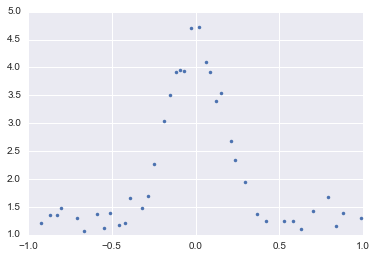

In [23]:
plt.plot(coord_13, fluor_13, marker='.', linestyle='none')

The data are somewhat different from those of the 14$^{th}$ cycle. The amplitude is approximately 3.5, with a shift of 1.25. The width is roughly 0.20 and the mean is around 0. 

In [24]:
p0 = np.array([3.5, 1.25, 0.20, 0])
# Extra arguments as a tuple
args = (coord_13.values, fluor_13.values)
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
popt

array([ 3.24947596,  1.28029515,  0.15785051, -0.00328868])

As seen from the best fit parameters, the width is approximately 0.158 for the 13$^{th}$ cycle.

In [25]:
hes = smnd.approx_hess(popt, log_post, args=args)
cov = -np.linalg.inv(hes)
err_a = np.sqrt(cov[0,0])
err_b = np.sqrt(cov[1,1])
err_width = np.sqrt(cov[2,2])
err_position = np.sqrt(cov[3,3])
print ('The error for A is', err_a)
print ('The error for b is', err_b)
print ('The error for the width is', err_width)
print ('The error for the position of the peak is', err_position)

The error for A is 0.0812301368519
The error for b is 0.0382808563036
The error for the width is 0.00517848656534
The error for the position of the peak is 0.00435326823646


Now, let's plot the theoretical gradient and the measurements together: 

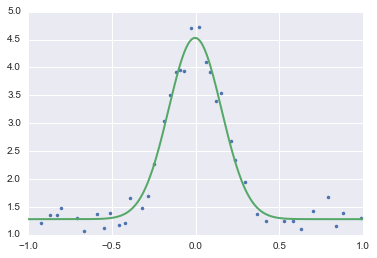

In [26]:
plt.plot(coord_13, fluor_13, marker='.', linestyle='none')
x = np.linspace(-1,1,200)
y = find_fluorescence(popt, x)
plt.plot(x,y)



The plot shows that our guess for the best fit curve is reasonable. Now, we move on to the 12$^{th}$ cycle. As before, we first plot the data:

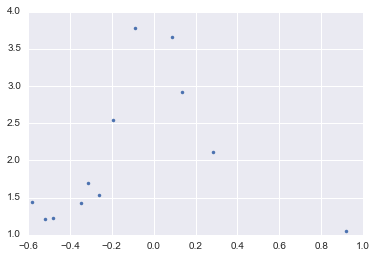

In [27]:
plt.plot(coord_12, fluor_12, marker='.', linestyle='none')

From the plot, we guess that  $A$, $B$, $w$ and $\mu$ are 3.5, 1.25, 0.15 and 0, respectively.

In [28]:
p0 = np.array([3.5, 1.25, 0.15, 0])
# Extra arguments as a tuple
args = (coord_12.values, fluor_12.values)
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
popt

array([  2.82758023e+00,   1.24713617e+00,   1.51849452e-01,
        -3.84065269e-04])

As seen from the best fit parameters, the width is approximately 0.152 for the 12$^{th}$ cycle. (We're so good at guessing :))

In [29]:
hes = smnd.approx_hess(popt, log_post, args=args)
cov = -np.linalg.inv(hes)
err_a = np.sqrt(cov[0,0])
err_b = np.sqrt(cov[1,1])
err_width = np.sqrt(cov[2,2])
err_position = np.sqrt(cov[3,3])
print ('The error for A is', err_a)
print ('The error for b is', err_b)
print ('The error for the width is', err_width)
print ('The error for the position of the peak is', err_position)

The error for A is 0.196724960092
The error for b is 0.0980875835302
The error for the width is 0.0146890206163
The error for the position of the peak is 0.00946427067665


Now, let's plot the theoretical gradient and the measurements together: 

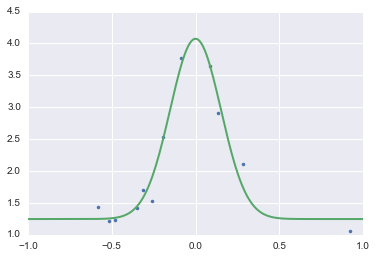

In [30]:
plt.plot(coord_12, fluor_12, marker='.', linestyle='none')
x = np.linspace(-1,1,200)
y = find_fluorescence(popt, x)
plt.plot(x,y)



The plot shows that our guess for the best fit curve is reasonable. Now, we move on to the 11$^{th}$ cycle. As before, we first plot the data:

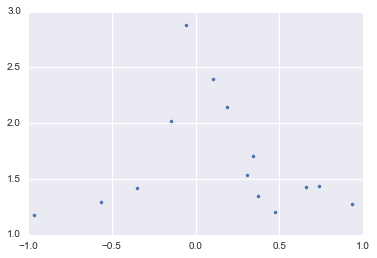

In [31]:
plt.plot(coord_11, fluor_11, marker='.', linestyle='none')

From the plot, we guess that  $A$, $B$, $w$ and $\mu$ are 1.75, 1.25, 0.20 and 0, respectively.

In [32]:
p0 = np.array([1.75, 1.25, 0.20, 0])
# Extra arguments as a tuple
args = (coord_11.values, fluor_11.values)
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
popt

array([ 1.5053858 ,  1.3236968 ,  0.14939181,  0.01089205])

As seen from the best fit parameters, the width is approximately 0.149 for the 11$^{th}$ cycle. 

In [33]:
hes = smnd.approx_hess(popt, log_post, args=args)
cov = -np.linalg.inv(hes)
err_a = np.sqrt(cov[0,0])
err_b = np.sqrt(cov[1,1])
err_width = np.sqrt(cov[2,2])
err_position = np.sqrt(cov[3,3])
print ('The error for A is', err_a)
print ('The error for b is', err_b)
print ('The error for the width is', err_width)
print ('The error for the position of the peak is', err_position)

The error for A is 0.127146142504
The error for b is 0.0522753066873
The error for the width is 0.018483734657
The error for the position of the peak is 0.0111898118167


Now, let's plot the theoretical gradient and the measurements together: 

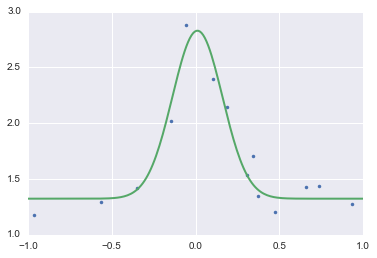

In [34]:
plt.plot(coord_11, fluor_11, marker='.', linestyle='none')
x = np.linspace(-1,1,200)
y = find_fluorescence(popt, x)
plt.plot(x,y)

The best fit curve shows that our initial guess highly likely converged to the right solution. 

3.1 (d) 

In [35]:
# Load data into DataFrame
df = pd.read_csv('../data/reeves_gradient_width_various_methods.csv', comment='#')

# Check it out
df.head()

,wt,wt.1,dl1/+; dl-venus/+,dl1/+; dl-venus/+.1,dl1/+; dl-venus/+.2,dl1/+; dl-gfp/+,dl1/+; dl-gfp/+.1,dl1/+; dl-gfp/+.2
0,wholemounts,cross-sections,anti-Dorsal,anti-Venus,Venus (live),anti-Dorsal,anti-GFP,GFP (live)
1,0.1288,0.1327,0.1482,0.1632,0.1666,0.2248,0.2389,0.2412
2,0.1554,0.1457,0.1503,0.1671,0.1753,0.1891,0.2035,0.1942
3,0.1306,0.1447,0.1577,0.1704,0.1705,0.1705,0.1943,0.2186
4,0.1413,0.1282,0.1711,0.1779,NaN,0.1735,0.2,0.2104


We first need to tidy the data. 

In [36]:
molten = pd.melt(df, var_name='genotype', value_name='gradient width')


In [37]:
molten = molten.dropna()


In [38]:
col1 = molten['genotype'].values
col2 = molten['gradient width'].values

In [39]:
col3 = []
index = 0
for i in range(len(col2)):
    if col2[index] == 'wholemounts':
        mystr = col2[index]
    elif col2[index] == 'cross-sections':
        mystr = col2[index]
    elif col2[index] == 'anti-Dorsal':
        mystr = col2[index]
    elif col2[index] == 'anti-Venus':
        mystr = col2[index]    
    elif col2[index] == 'Venus (live)':
        mystr = col2[index]
    elif col2[index] == 'anti-Dorsal':
        mystr = col2[index]
    elif col2[index] == 'anti-GFP':
        mystr = col2[index]
    elif col2[index] == 'GFP (live)':
        mystr = col2[index]
    col3.append(mystr)
    index += 1

In [40]:
molten['staining method'] = col3

In [41]:
molten.head()

,genotype,gradient width,staining method
0,wt,wholemounts,wholemounts
1,wt,0.1288,wholemounts
2,wt,0.1554,wholemounts
3,wt,0.1306,wholemounts
4,wt,0.1413,wholemounts


In [42]:
molten = molten[molten['gradient width'] != 'wholemounts']
molten = molten[molten['gradient width'] != 'cross-sections']
molten = molten[molten['gradient width'] != 'anti-Dorsal']
molten = molten[molten['gradient width'] != 'anti-Venus']
molten = molten[molten['gradient width'] != 'Venus (live)']
molten = molten[molten['gradient width'] != 'anti-GFP']
molten = molten[molten['gradient width'] != 'GFP (live)']


In [43]:
molten.head()

,genotype,gradient width,staining method
1,wt,0.1288,wholemounts
2,wt,0.1554,wholemounts
3,wt,0.1306,wholemounts
4,wt,0.1413,wholemounts
5,wt,0.1557,wholemounts


In [44]:
col1 = molten['genotype'].values
index = 0
for i in range(len(col1)):
    if col1[index] == 'wt.1':
        col1[index] = 'wt'
    elif col1[index] == 'dl1/+; dl-venus/+.1':
        col1[index] = 'dl1/+; dl-venus/+'
    elif col1[index] == 'dl1/+; dl-venus/+.2':
        col1[index] = 'dl1/+; dl-venus/+'
    elif col1[index] == 'dl1/+; dl-gfp/+.1':
        col1[index] = 'dl1/+; dl-gfp/+'
    elif col1[index] == 'dl1/+; dl-gfp/+.2':
        col1[index] = 'dl1/+; dl-gfp/+'
    index += 1

In [45]:
molten['genotype'] = col1

In [46]:
molten
moltenbackup = molten

In [47]:
col1 = molten['genotype'].values
col2 = molten['gradient width'].values
index = 0
for i in range(len(col1)):
    if col1[index] == 'wt':
        col1[index] = 1.0
    elif col1[index] == 'dl1/+; dl-venus/+':
        col1[index] = 2.0
    elif col1[index] == 'dl1/+; dl-gfp/+':
        col1[index] = 3.0
    index += 1
index = 0
for i in range(len(col2)):
    col2[index] = float(col2[index])
    col1[index] = float(col1[index])
    index += 1
molten['genotype'] = np.reshape(col1, len(col1))
molten['gradient width'] = np.reshape(col2, len(col2))
molten['staining method'] = np.reshape(molten['staining method'], len(molten['staining method']))
molten['genotype'] = pd.Series(molten['genotype'])
molten['gradient width'] = pd.Series(molten['gradient width']).tolist()
molten['staining method'] = pd.Series(molten['staining method']).tolist()

In [48]:
newMolten = molten.reset_index(drop = True)
newMolten.columns = ['Genotype', 'Gradient Width', 'Staining Method']
newMolten.dropna()

,Genotype,Gradient Width,Staining Method
0,1,0.1288,wholemounts
1,1,0.1554,wholemounts
2,1,0.1306,wholemounts
3,1,0.1413,wholemounts
4,1,0.1557,wholemounts
5,1,0.1689,wholemounts
6,1,0.1417,wholemounts
7,1,0.1315,wholemounts
8,1,0.1664,wholemounts
9,1,0.1560,wholemounts


Now, we're ready to plot it. We will use a swarmplot because it makes it easier to compare the gradient widths of each genotype and each staining method. Also, note that the values 1, 2 and 3 on the x-axis correspond to the wild type, dl1/+; dl-venus/+ and dl1/+; dl-gfp/+, respectively. 

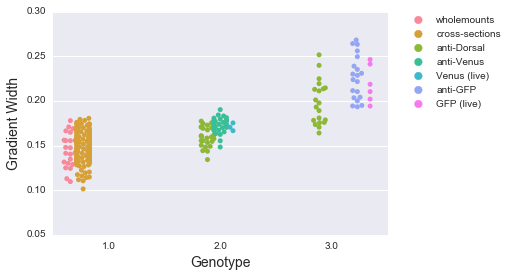

In [49]:
plt = sns.swarmplot(x="Genotype", y='Gradient Width', hue='Staining Method', data= newMolten, split = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In 3.3, we derive a formula for the combined error of n independent experiments. Using the formula, we can find the combined variances of both the Venus fusion and the wild type cross-section. Typically the lower combined variance is more preferable, as it gives a more exact measure of the Dorsal gradient. Hence, we will pick the lower of the two:

First, we find combined variance corresponding to the wild type cross-sections:

In [64]:
cross = newMolten[newMolten['Staining Method'] == 'cross-sections']['Gradient Width'].values

In [66]:
my_sum = 0
for i in cross:
    my_sum += 1/cross[i]**2
varian = my_sum**-1

D:\Anacondabi103\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [72]:
print ('The combined variance of wild type cross-sections is', varian)

The combined variance of wild type cross-sections is 0.000182602368421


Next, we find the combined variance for the Venus fusion:

In [82]:
venus = newMolten[newMolten['Staining Method'] == 'Venus (live)']['Gradient Width'].values
venus = list(venus)
venus.extend(list(newMolten[newMolten['Staining Method'] == 'anti-Dorsal']['Gradient Width'].values))
venus.extend(list(newMolten[newMolten['Staining Method'] == 'anti-Venus']['Gradient Width'].values))

In [83]:
my_sum = 0
for i in range(len(venus)):
    my_sum += 1/venus[i]**2
varian = my_sum**-1

In [85]:
print ('The combined variance for the Venus fusion is', varian) 

The combined variance for the Venus fusion is 0.000363546741088


Notice that compared to the wild type gold standard, Venus fusion has a higher variance. This suggests that Venus fusion is less preferable to the wild type cross section gold standard since it has a higher measurement uncertainty. While using the Venus fusion can be considered "reasonable", depending on how we define reasonable, it is an inferior choice to the gold standard wild type. 